In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from itertools import combinations
from collections import Counter
import random
import warnings # will need this one to suppress some warnings
from scipy.stats import ttest_ind

%matplotlib inline

# Goal of the project

1) The goal of the project is to analyze a provided dataset about the results of math exams for students of ages between 15 and 22. This dataset (after analysis and modification).

2) Prepare this data set to use it in machine learning process. This dataset will be used for training a model capable of predicting math scores based on specific traits of students.

3) Write conclusions based on the work done.

# Visual inspection of data

There are 395 rows and 30 columns in a dataset. From a first glance most columns look rather complete (not too many missing values) - this, however, will be further explored later.

There are 17 columns of type "object", one column of type "int64" and 12 columns of type "float64" (one of them is our target variable "score"). However, it seems that 9 float variables (Medu, Fedu, traveltime, studytime, failures, famrel, freetime, goout, health) are categorical by nature. Moreover, some of them (traveltime, studytime, failures, famrel, freetime, goout, health) are ordinal.

In [31]:
df_students = pd.read_csv('stud_math.xls')
df_students.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,...,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,...,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,...,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,...,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,...,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [32]:
# renaming a column with ,
df_students.rename(columns={'studytime, granular':'studytime_granular'}, inplace=True)

In [33]:
df_students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              395 non-null    object 
 1   sex                 395 non-null    object 
 2   age                 395 non-null    int64  
 3   address             378 non-null    object 
 4   famsize             368 non-null    object 
 5   Pstatus             350 non-null    object 
 6   Medu                392 non-null    float64
 7   Fedu                371 non-null    float64
 8   Mjob                376 non-null    object 
 9   Fjob                359 non-null    object 
 10  reason              378 non-null    object 
 11  guardian            364 non-null    object 
 12  traveltime          367 non-null    float64
 13  studytime           388 non-null    float64
 14  failures            373 non-null    float64
 15  schoolsup           386 non-null    object 
 16  famsup  

In [34]:
# rows with missing scores don't really make much sense
df_students.dropna(subset=['score'], inplace=True)

In [35]:
# define numeric columns manually
cols_numeric = ['age', 'absences', 'score']

# remaining columns are considered categorical
cols_categorical = list(
    filter(lambda x: x not in cols_numeric, list(df_students.columns)))

# keeping ordinal columns (a subset of categorical) in a separate list
# for convenience (just in case)
cols_ordinal = ['traveltime', 'studytime', 'failures',
                'famrel', 'freetime', 'goout', 'health']

print(
    f'Numeric columns are: {cols_numeric}. \n\nCategorical columns are: {cols_categorical}.')

Numeric columns are: ['age', 'absences', 'score']. 

Categorical columns are: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'studytime_granular', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health'].


# Definitions of helper functions are in a cell below

In [36]:
def describe_dataframe(df, cols_numeric):
    '''
    Creates a dataframe with useful descriptors
    for all the columns in df (passed as argument).

    Please note that cols_numeric (a list of columns
    that are considered numeric) is mandatory.
    '''

    row_cnt = df.shape[0]

    # these lists will be populated below and
    # zipped into a dataframe in the end
    cols = []
    col_type = []
    cnt_filled = []
    unique = []
    missing = []
    missing_percent = []
    freq_dict = []

    for c in df.columns:
        cols.append(c)
        if c in cols_numeric:
            col_type.append('numeric')
        else:
            col_type.append('categorical')
        cnt_filled.append(df[c].count())
        unique.append(df[c].nunique())
        missing.append(row_cnt - df[c].count())
        missing_percent.append(round((row_cnt-df[c].count()) / row_cnt, 2)*100)
        # freq_dict is an important column that will later be used to replace NaN
        # for categorical variables based on their frequency in a dataset
        # for numerics it's calculated as well, but most likely won't be used
        freq_dict.append({k: round(
            100*v/df[c].count()) for k, v in dict(df[c].value_counts().sort_values(ascending=True)).items()})

    data_tuples = list(zip(cols, col_type, cnt_filled,
                           unique, missing, missing_percent, freq_dict))
    result = pd.DataFrame(data_tuples, columns=[
                          'column', 'col_type', 'not_null', 'unique', 'null', 'null_percent', 'freq_dict'])

    return result


def create_grid(col_list, grid_cols):
    '''
    Creates a grid from the list of given columns
    and a required grid column count. The grid can
    later be used for plotting.

    For example, if a list is 23 item long and
    user wants a grid to be 4 columns wide then
    a grid of 4 columns and 6 rows will be created
    after calling create_grid(col_list, 4)
    '''

    grid_rows = math.ceil(len(col_list) / grid_cols)
    fig, axs = plt.subplots(nrows=grid_rows, ncols=grid_cols, figsize=(25, 25))
    return fig, axs


def show_values(plot):
    '''
    Adds values to bars in bar charts.
    Used only inside other functions 
    that are defined below.
    '''
    for p in plot.patches:
        height = p.get_height()
        if height != 0:
            plot.text(p.get_x()+p.get_width()/2.,
                      height/2 + 0.1, height, ha="center")


def get_iqr_flexible(s, low_perc=0.25, high_perc=0.75):
    '''
    Returns some basic statistics related to IQR.
    It's flexible because by default this function
    delivers 25, 50, 75 percentiles and IQR, however,
    if you set a different low_perc and high_perc values 
    ther results will be different.

    Of course, if you, for example, set low_perc = 0.1
    and high_perc = 0.9 the result won't actually be IQR
    anymore because it will have nothing to do with quartiles. 
    Name IQR is used here just for convenience and becauss in
    most cases standard will be used anyway.
    '''
    median = s.median()
    iqr = s.quantile(0.75) - s.quantile(0.25)
    perc25 = s.quantile(0.25)
    perc75 = s.quantile(0.75)
    lower_outliers = Counter(s[(s < perc25 - 1.5*iqr)])
    higher_outliers = Counter(s[(s > perc75 + 1.5*iqr)])
    print(
        f'Column name: {s.name}. Median: {median}. Lower percentile ({low_perc}): {perc25}.')
    print(
        f'Higher percentile ({high_perc}): {perc75}. IQR: {iqr}.')
    print(
        f'Lower outliers: {lower_outliers}.')
    print(
        f'Higher outliers: {higher_outliers}.')
    return {'perc25': perc25, 'median': median, 'perc75': perc75, 'iqr': iqr}


def mass_visualize_grid(var_type, col_list, grid_cols, data_frame):
    '''
    Visualizes all the variables (passed as 
    coll_list) on a grid of a dynamic
    width (controlled using grid_cols argument)
    from the data set (passed as data_frame).

    It's important to pass var_type argument that
    requires one of 2 values: 'cat' for categorical
    and 'num' for numeric variables, because it 
    determines chart type (countplot or distplot)
    '''

    # calling create_grid first
    fig, axs = create_grid(col_list, grid_cols)

    # creating countplots on row and position (pos)
    # that are dynamically calculated
    for i, col in enumerate(col_list):
        row = i // grid_cols
        pos = i % grid_cols

        # if multiple rows in a grid
        if len(axs.shape) > 1:
            ax = axs[row][pos]
        # if only one row in a grid
        else:
            ax = axs[pos]

        if var_type == 'cat':
            # countplot in case of a categorical variable
            plot = sns.countplot(x=col, data=data_frame, ax=ax)
        else:
            # distplot in case of numeric variable
            # ignore filterwarning because if there are no outliers
            # one of the distplot calls below can show a warning
            # and that is OK because there can easily be no outliers
            # to visualize
            warnings.filterwarnings('ignore')
            temp_stats = get_iqr_flexible(data_frame[col], 0.25, 0.75)
            plot = sns.distplot(data_frame[col].loc[data_frame[col].between(
                temp_stats['perc25'] - 1.5*temp_stats['iqr'], temp_stats['perc75'] + 1.5*temp_stats['iqr'])], kde=False, ax=ax, label='Within IQR')
            sns.distplot(data_frame[col].loc[data_frame[col] < (
                temp_stats['perc25'] - 1.5*temp_stats['iqr'])], kde=False, ax=ax, label='Below IQR')
            sns.distplot(data_frame[col].loc[data_frame[col] > (
                temp_stats['perc75'] + 1.5*temp_stats['iqr'])], kde=False, ax=ax, label='Above IQR')
            ax.legend()
            # turning warnings back on
            warnings.filterwarnings('default')

        # adding value counts to bars
        show_values(plot)


def mass_visualize_line(var_type, col_list, data_frame):
    '''
    Sometimes it's easier to see the values on charts
    printed line by line rather than in a grid layout.
    This procedure creates a line by line charts
    for multiple columns (col_list) of target 
    dataframe (data_frame).

    It's important to pass var_type argument that
    requires one of 2 values: 'cat' for categorical
    and 'num' for numeric variables, because it 
    determines chart type (countplot or distplot)    
    '''
    fig, ax = plt.subplots(figsize=(14, 4))

    for col in col_list:
        if var_type == 'cat':
            plot = sns.countplot(x=col, data=data_frame)
        else:
            # distplot in case of numeric variable
            # ignore filterwarning because if there are no outliers
            # one of the distplot calls below can show a warning
            # and that is OK because there can easily be no outliers
            # to visualize
            warnings.filterwarnings('ignore')
            temp_stats = get_iqr_flexible(data_frame[col], 0.25, 0.75)
            plot = sns.distplot(data_frame[col].loc[data_frame[col].between(
                temp_stats['perc25'] - 1.5*temp_stats['iqr'], temp_stats['perc75'] + 1.5*temp_stats['iqr'])], kde=False, ax=ax, label='Within IQR')
            sns.distplot(data_frame[col].loc[data_frame[col] < (
                temp_stats['perc25'] - 1.5*temp_stats['iqr'])], kde=False, ax=ax, label='Below IQR')
            sns.distplot(data_frame[col].loc[data_frame[col] > (
                temp_stats['perc75'] + 1.5*temp_stats['iqr'])], kde=False, ax=ax, label='Above IQR')
            ax.legend()
            # turning warnings back on
            warnings.filterwarnings('default')

        # adding value counts to bars
        show_values(plot)
        plt.show()


def fill_na_by_frequency(df_descr, col):
    '''
    This function is used to replace NaN for categorical
    columns with values based on the frequency of non-missing values.
    What that means is that if, for example, we take column "guardian"
    then missing values will be filled with "mother" (69% probability),
    "father" (24% probability) and "other" (7% probability).

    For this function to work df_description should be passed as an argument.
    This table is populated using describe_dataframe function (defined 
    above) and contains a column called freq_dict that looks like this (for
    column "guardian" as an example): {'other': 7.0, 'father': 24.0, 'mother': 69.0}.
    Numbers correspond to the frequency of every possible distinct value.

    IMPORTANT: this function can't be applied using df.fillna() because the result
    must be different for every row it applies to, whereas fillna() replaces all NaN
    with a single value. Therefore apply() should be used on a column (series)
    '''

    # reading freq_dict column from df_descr dataframe only for
    # columns of type 'categorical' that contain empty values
    freq_dict = df_descr[(df_descr['null'] > 0) & (df_descr['col_type']
                                                   == 'categorical') & (df_descr['column'] == col)]['freq_dict']

    # do something only if freq_dict exists after the previous step
    if len(freq_dict) > 0:
        rnd_check = round(random.random()*100)
        cumulative = 0
        for k, v in freq_dict.values[0].items():
            # cumulative is used to correctly assess the probability
            # for example, if we take {'other': 7.0, 'father': 24.0, 'mother': 69.0}
            # then "other" will be picked is rnd_check if <= 7, "father" will be
            # picked if rnd_check <= 31 and "mother" will be picked in al the other cases
            cumulative += v
            if rnd_check <= cumulative:
                #print(f'Random number is: {rnd_check}. Value is: {k}')
                return k
        # the last option
        return k
        #print(f'Random number is: {rnd_check}. Value is: {k}')


def get_boxplot(column, target, df_data):
    '''
    Creates a boxplot for each distinct value of categorical
    column and a target variable
    '''
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y=target, data=df_data, ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


def get_stat_dif(column,  df_data):
    '''
    Student's t-test for all combinations of values for each categorical column
    '''
    cols = df_data.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df_data.loc[df_data.loc[:, column] == comb[0], 'score'],
                     df_data.loc[df_data.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Bonferroni correction applied to avoid excessive amount of false negatives
            print('Statistically significant differences found for column:', column)
            return column

# Inspection of categorical variables

In [37]:
df_descriptions = describe_dataframe(df_students, cols_numeric)
df_descriptions

,column,col_type,not_null,unique,null,null_percent,freq_dict
0,school,categorical,389,2,0,0.0,"{'MS': 12.0, 'GP': 88.0}"
1,sex,categorical,389,2,0,0.0,"{'M': 48.0, 'F': 52.0}"
2,age,numeric,389,8,0,0.0,"{22: 0.0, 21: 0.0, 20: 1.0, 19: 5.0, 18: 21.0,..."
3,address,categorical,374,2,15,4.0,"{'R': 22.0, 'U': 78.0}"
4,famsize,categorical,362,2,27,7.0,"{'LE3': 30.0, 'GT3': 70.0}"
5,Pstatus,categorical,344,2,45,12.0,"{'A': 10.0, 'T': 90.0}"
6,Medu,categorical,386,5,3,1.0,"{0.0: 1.0, 1.0: 15.0, 3.0: 25.0, 2.0: 26.0, 4...."
7,Fedu,categorical,365,6,24,6.0,"{40.0: 0.0, 0.0: 1.0, 1.0: 21.0, 4.0: 24.0, 3...."
8,Mjob,categorical,370,5,19,5.0,"{'health': 9.0, 'teacher': 15.0, 'at_home': 16..."
9,Fjob,categorical,353,5,36,9.0,"{'health': 4.0, 'at_home': 5.0, 'teacher': 8.0..."


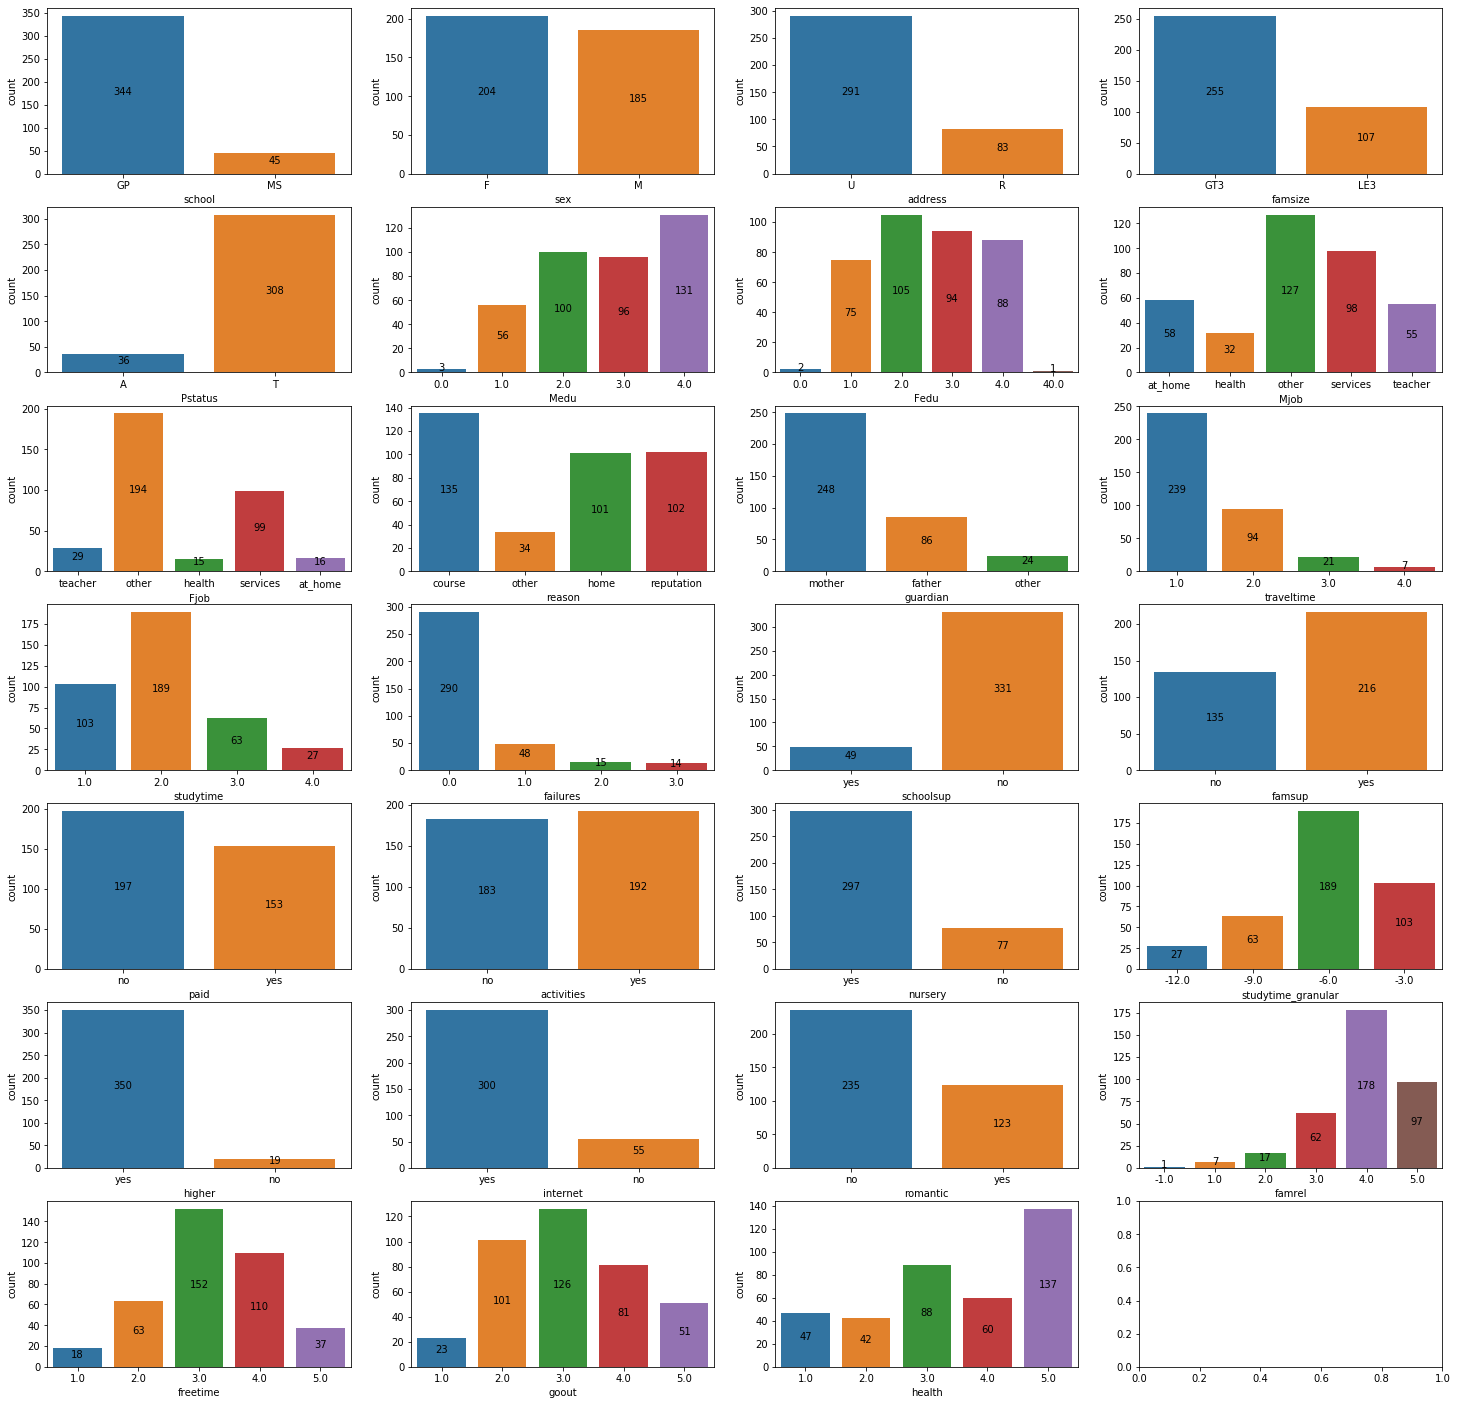

In [38]:
mass_visualize_grid('cat', cols_categorical, 4, df_students)

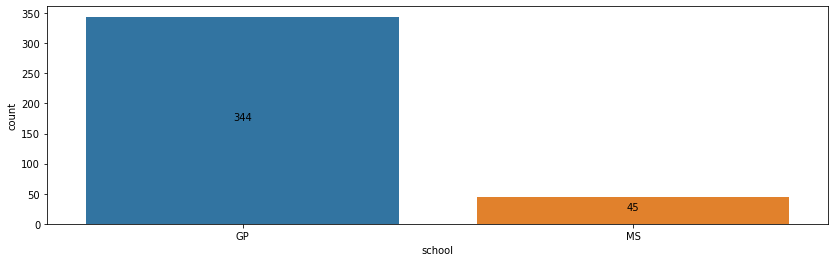

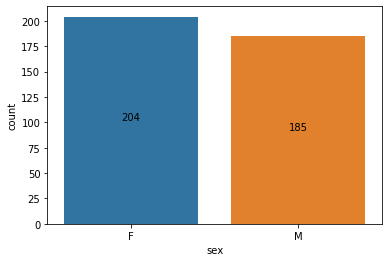

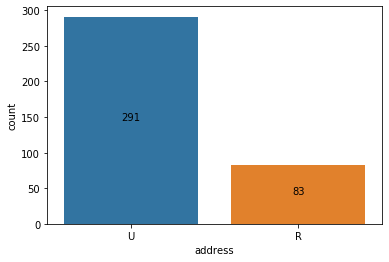

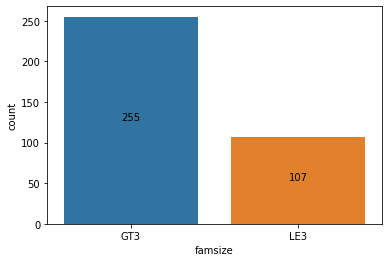

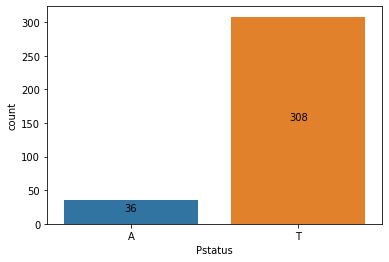

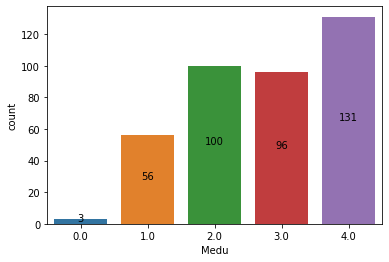

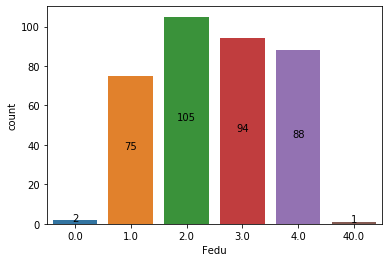

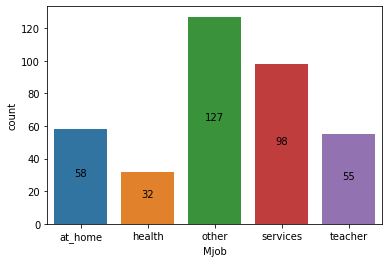

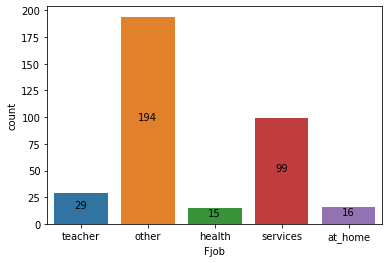

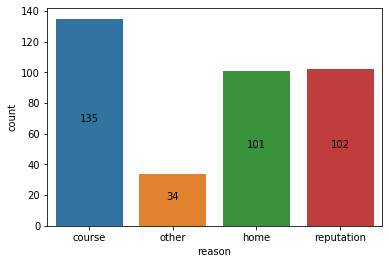

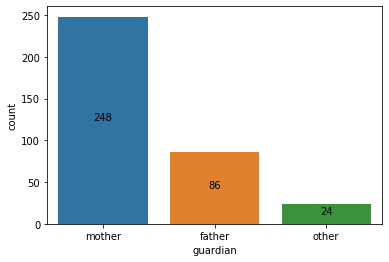

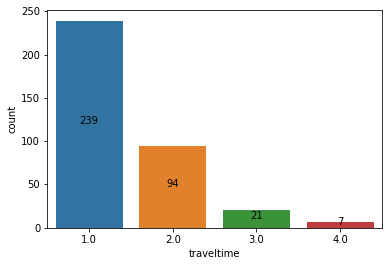

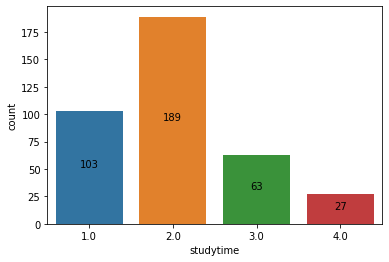

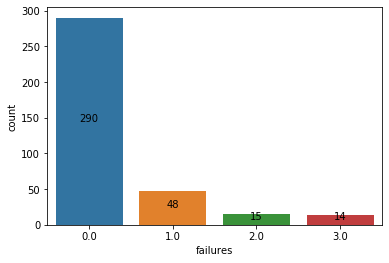

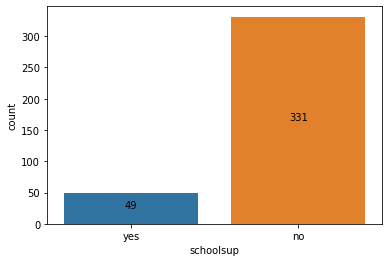

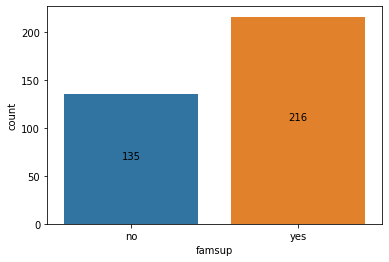

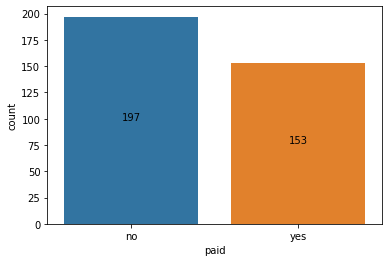

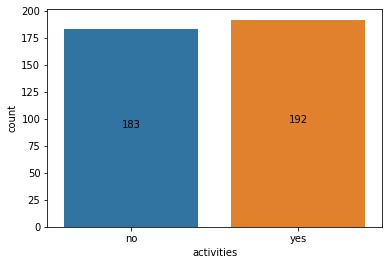

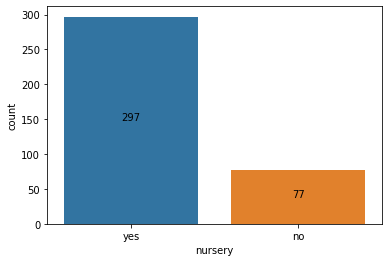

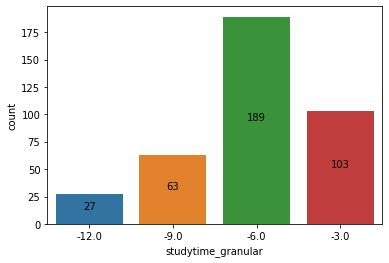

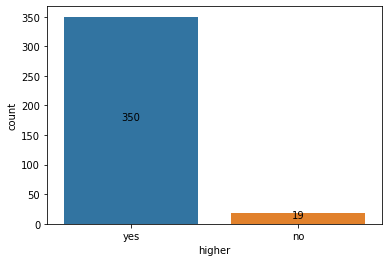

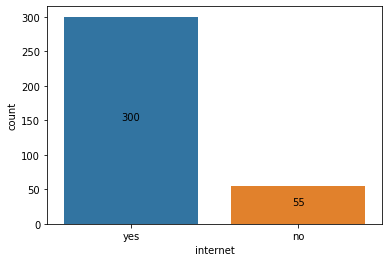

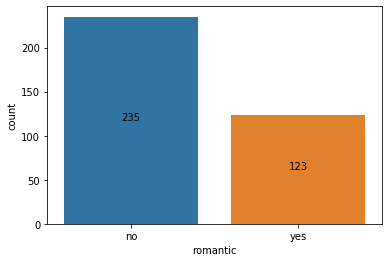

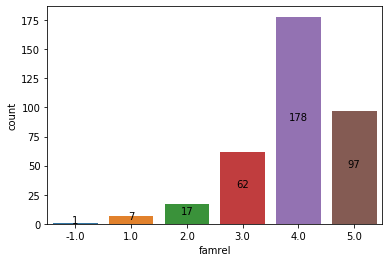

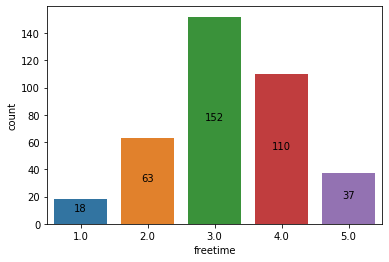

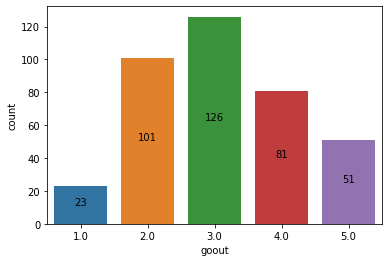

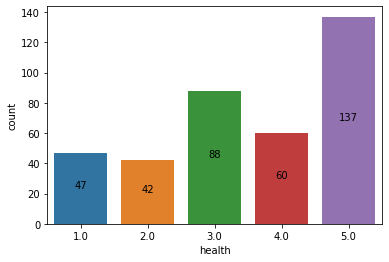

In [39]:
# creating line by line visualization to see the values better
mass_visualize_line('cat', cols_categorical, df_students)

# Preliminary notes after the inspection of countplots for categorical variables
1) It seems that there are only 2 schools present in this list (GP and MS). And most data comes from GP. If it is really an abbreviation of a school name then this data set might not be representative for other schools. Need to try and find out what that really is.

2) Fedu (mother's education) has some values that seem to be incorrectly entered (40). I think they should simply be changed to higher education (4).

3) Column failures doesn't make much sense to me because it seems that 0 might mean both that there are no failures and that there are more than 3 failures (at least based on a column definition). Looks like this column is a good candidate for deletion.

4) Column "studytime_granular" is not mentioned in a dataset description at all. By the looks of data I can't really decide what it means. However, this column won't be deleted right away. It needs to be further analyzed. Maybe it's a good predictor of some sort. In this case it can be kept, but the meaning of it should be clarified.

5) There are values -1 in column famrel. It contradicts the description of that column. I believe, that -1 should be changed to 1 because it might be a typo.

6) Missing values can be replaced with actual values based on their frequency distribution (column freq_dict in a dataframe df_description). Of course, a more simple approach can  be used as well (replacing missing values with mode), but this approach is biased towards the most popular value and doesn't take into account the fact that other values can also appear in a sample. Please see a description of a function fill_na_by_frequency() in a corresponding section above.

# Modifying dataframe and categorical columns based on previous findings

In [40]:
# manually re-entering incorrect values
df_students.loc[df_students[df_students['Fedu'] > 4].index[0], 'Fedu'] = 4
df_students.loc[df_students[df_students['famrel']  == -1].index[0], 'famrel'] = 1

In [41]:
# Filling missing values in all categorical columns using fill_na_by_frequency()
# This is a preferred approach (please see preliminary notes above)
for col in cols_categorical:
    df_students[col] = df_students[col].apply(
        lambda x: fill_na_by_frequency(df_descriptions, col) if pd.isna(x) else x)

# Filling missing values in all categorical columns using mode()
# This is a least preferred approach - that's why it sommented out
# (please see preliminary notes above)
# for col in cols_categorical:
#     col_mode = df_students[col].mode().values[0]
#     df_students[col].fillna(col_mode, inplace=True)

In [42]:
# removing column failures
df_students.drop('failures', axis=1, inplace=True)
cols_categorical.remove('failures')

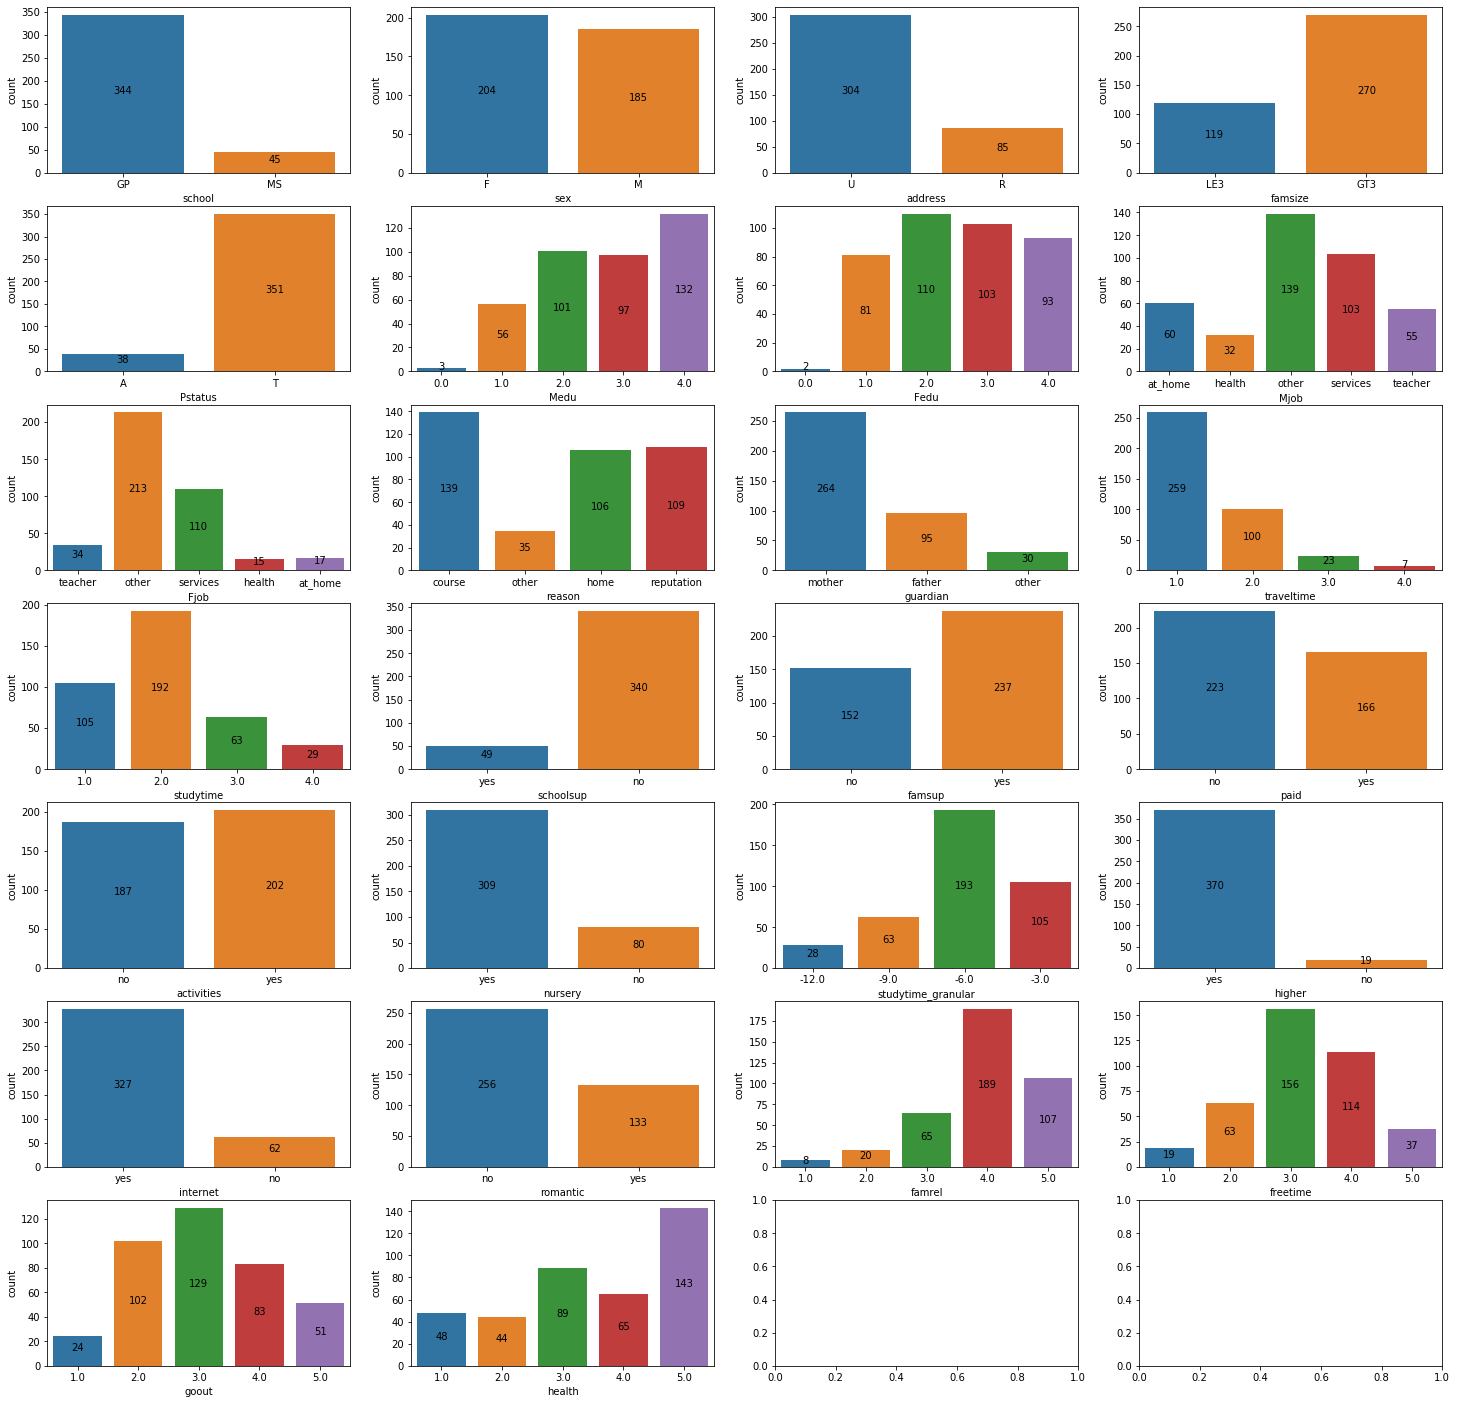

In [43]:
# visualizing categorical columns one more time to check the result of NaN filling
mass_visualize_grid('cat', cols_categorical, 4, df_students)

# Inspecting numeric variables

Column name: age. Median: 17.0. Lower percentile (0.25): 16.0.
Higher percentile (0.75): 18.0. IQR: 2.0.
Lower outliers: Counter().
Higher outliers: Counter({22: 1}).
Column name: absences. Median: 4.0. Lower percentile (0.25): 0.0.
Higher percentile (0.75): 8.0. IQR: 8.0.
Lower outliers: Counter().
Higher outliers: Counter({22.0: 3, 25.0: 1, 54.0: 1, 26.0: 1, 56.0: 1, 24.0: 1, 28.0: 1, 385.0: 1, 21.0: 1, 75.0: 1, 30.0: 1, 38.0: 1, 40.0: 1, 23.0: 1, 212.0: 1}).
Column name: score. Median: 55.0. Lower percentile (0.25): 40.0.
Higher percentile (0.75): 70.0. IQR: 30.0.
Lower outliers: Counter().
Higher outliers: Counter().


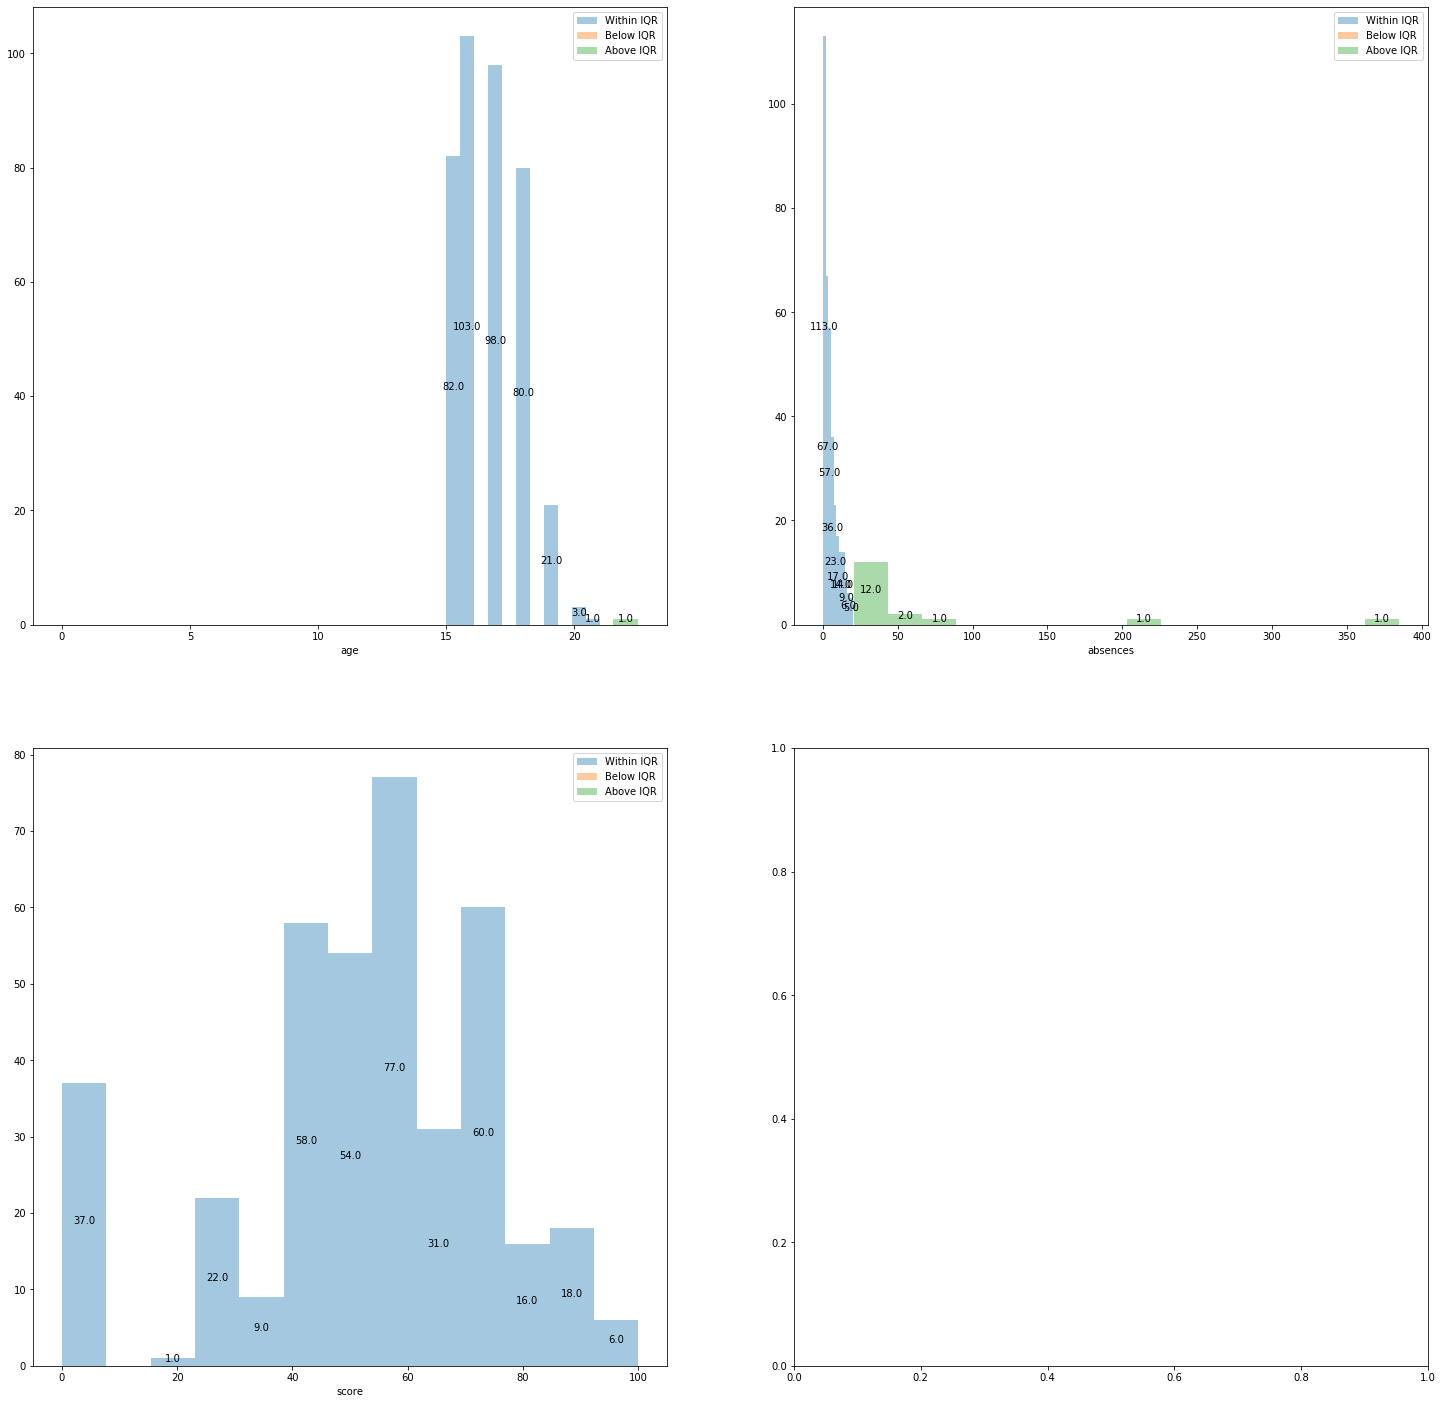

In [44]:
mass_visualize_grid('num', cols_numeric, 2, df_students)

In [45]:
get_iqr_flexible(df_students['age'])

Column name: age. Median: 17.0. Lower percentile (0.25): 16.0.
Higher percentile (0.75): 18.0. IQR: 2.0.
Lower outliers: Counter().
Higher outliers: Counter({22: 1}).


{'perc25': 16.0, 'median': 17.0, 'perc75': 18.0, 'iqr': 2.0}

In [46]:
get_iqr_flexible(df_students['absences'])

Column name: absences. Median: 4.0. Lower percentile (0.25): 0.0.
Higher percentile (0.75): 8.0. IQR: 8.0.
Lower outliers: Counter().
Higher outliers: Counter({22.0: 3, 25.0: 1, 54.0: 1, 26.0: 1, 56.0: 1, 24.0: 1, 28.0: 1, 385.0: 1, 21.0: 1, 75.0: 1, 30.0: 1, 38.0: 1, 40.0: 1, 23.0: 1, 212.0: 1}).


{'perc25': 0.0, 'median': 4.0, 'perc75': 8.0, 'iqr': 8.0}

In [47]:
get_iqr_flexible(df_students['score'])

Column name: score. Median: 55.0. Lower percentile (0.25): 40.0.
Higher percentile (0.75): 70.0. IQR: 30.0.
Lower outliers: Counter().
Higher outliers: Counter().


{'perc25': 40.0, 'median': 55.0, 'perc75': 70.0, 'iqr': 30.0}

In [48]:
df_students['age'].value_counts().sort_index()

15     82
16    103
17     98
18     80
19     21
20      3
21      1
22      1
Name: age, dtype: int64

In [49]:
df_students['absences'].value_counts().sort_index()

0.0      110
1.0        3
2.0       60
3.0        7
4.0       52
5.0        5
6.0       30
7.0        6
8.0       20
9.0        3
10.0      17
11.0       2
12.0      12
13.0       2
14.0      12
15.0       2
16.0       7
17.0       1
18.0       5
19.0       1
20.0       4
21.0       1
22.0       3
23.0       1
24.0       1
25.0       1
26.0       1
28.0       1
30.0       1
38.0       1
40.0       1
54.0       1
56.0       1
75.0       1
212.0      1
385.0      1
Name: absences, dtype: int64

In [50]:
df_students['score'].value_counts().sort_index()

0.0      37
20.0      1
25.0      7
30.0     15
35.0      9
40.0     31
45.0     27
50.0     54
55.0     46
60.0     31
65.0     31
70.0     27
75.0     33
80.0     16
85.0      6
90.0     12
95.0      5
100.0     1
Name: score, dtype: int64

# Preliminary notes after inspecting numeric variables
1) Target variable score had some missing values. Rows with missing values were removed in the beginning. In general, the column looks fine. What seems weird though is that 37 values have a score 0. It might mean that student did not attend an exam at all. This most likely has nothing to do with the score so these rows will be dropped. Another model can be created to predict if a student will or will not attend an exam at all, but that's a different analysis.

2) Column age seems to contain one value that is technically an outlier (22). But it should not be removed because we know that this is a valid top border of age interval (based on a task description).

3) Column absences has a rather long list of outliers. Below is a dictionary with absence as a key and count as a value. Only 2 values are far above the limit (212 and 385, which is especially suspicious). 

Speaking of the remaining outliers (22-75), I would leave those below 30 in a set as well even though technically they are > 75th percentile + 1.5*IQR

{22.0: 3, 25.0: 1, 54.0: 1, 26.0: 1, 56.0: 1, 24.0: 1, 28.0: 1, 385.0: 1, 21.0: 1, 75.0: 1, 30.0: 1, 38.0: 1, 40.0: 1, 23.0: 1, 212.0: 1}

In [51]:
df_students = df_students[df_students['score'] > 0]
df_students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352 entries, 0 to 394
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              352 non-null    object 
 1   sex                 352 non-null    object 
 2   age                 352 non-null    int64  
 3   address             352 non-null    object 
 4   famsize             352 non-null    object 
 5   Pstatus             352 non-null    object 
 6   Medu                352 non-null    float64
 7   Fedu                352 non-null    float64
 8   Mjob                352 non-null    object 
 9   Fjob                352 non-null    object 
 10  reason              352 non-null    object 
 11  guardian            352 non-null    object 
 12  traveltime          352 non-null    float64
 13  studytime           352 non-null    float64
 14  schoolsup           352 non-null    object 
 15  famsup              352 non-null    object 
 16  paid    

In [52]:
df_students = df_students[df_students['absences'] < 30]
df_students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 0 to 394
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              334 non-null    object 
 1   sex                 334 non-null    object 
 2   age                 334 non-null    int64  
 3   address             334 non-null    object 
 4   famsize             334 non-null    object 
 5   Pstatus             334 non-null    object 
 6   Medu                334 non-null    float64
 7   Fedu                334 non-null    float64
 8   Mjob                334 non-null    object 
 9   Fjob                334 non-null    object 
 10  reason              334 non-null    object 
 11  guardian            334 non-null    object 
 12  traveltime          334 non-null    float64
 13  studytime           334 non-null    float64
 14  schoolsup           334 non-null    object 
 15  famsup              334 non-null    object 
 16  paid    

Column name: age. Median: 17.0. Lower percentile (0.25): 16.0.
Higher percentile (0.75): 17.75. IQR: 1.75.
Lower outliers: Counter().
Higher outliers: Counter({22: 1, 21: 1}).
Column name: absences. Median: 4.0. Lower percentile (0.25): 2.0.
Higher percentile (0.75): 8.0. IQR: 6.0.
Lower outliers: Counter().
Higher outliers: Counter({18.0: 5, 20.0: 4, 22.0: 3, 25.0: 1, 26.0: 1, 24.0: 1, 28.0: 1, 21.0: 1, 19.0: 1, 23.0: 1}).
Column name: score. Median: 55.0. Lower percentile (0.25): 50.0.
Higher percentile (0.75): 70.0. IQR: 20.0.
Lower outliers: Counter().
Higher outliers: Counter().


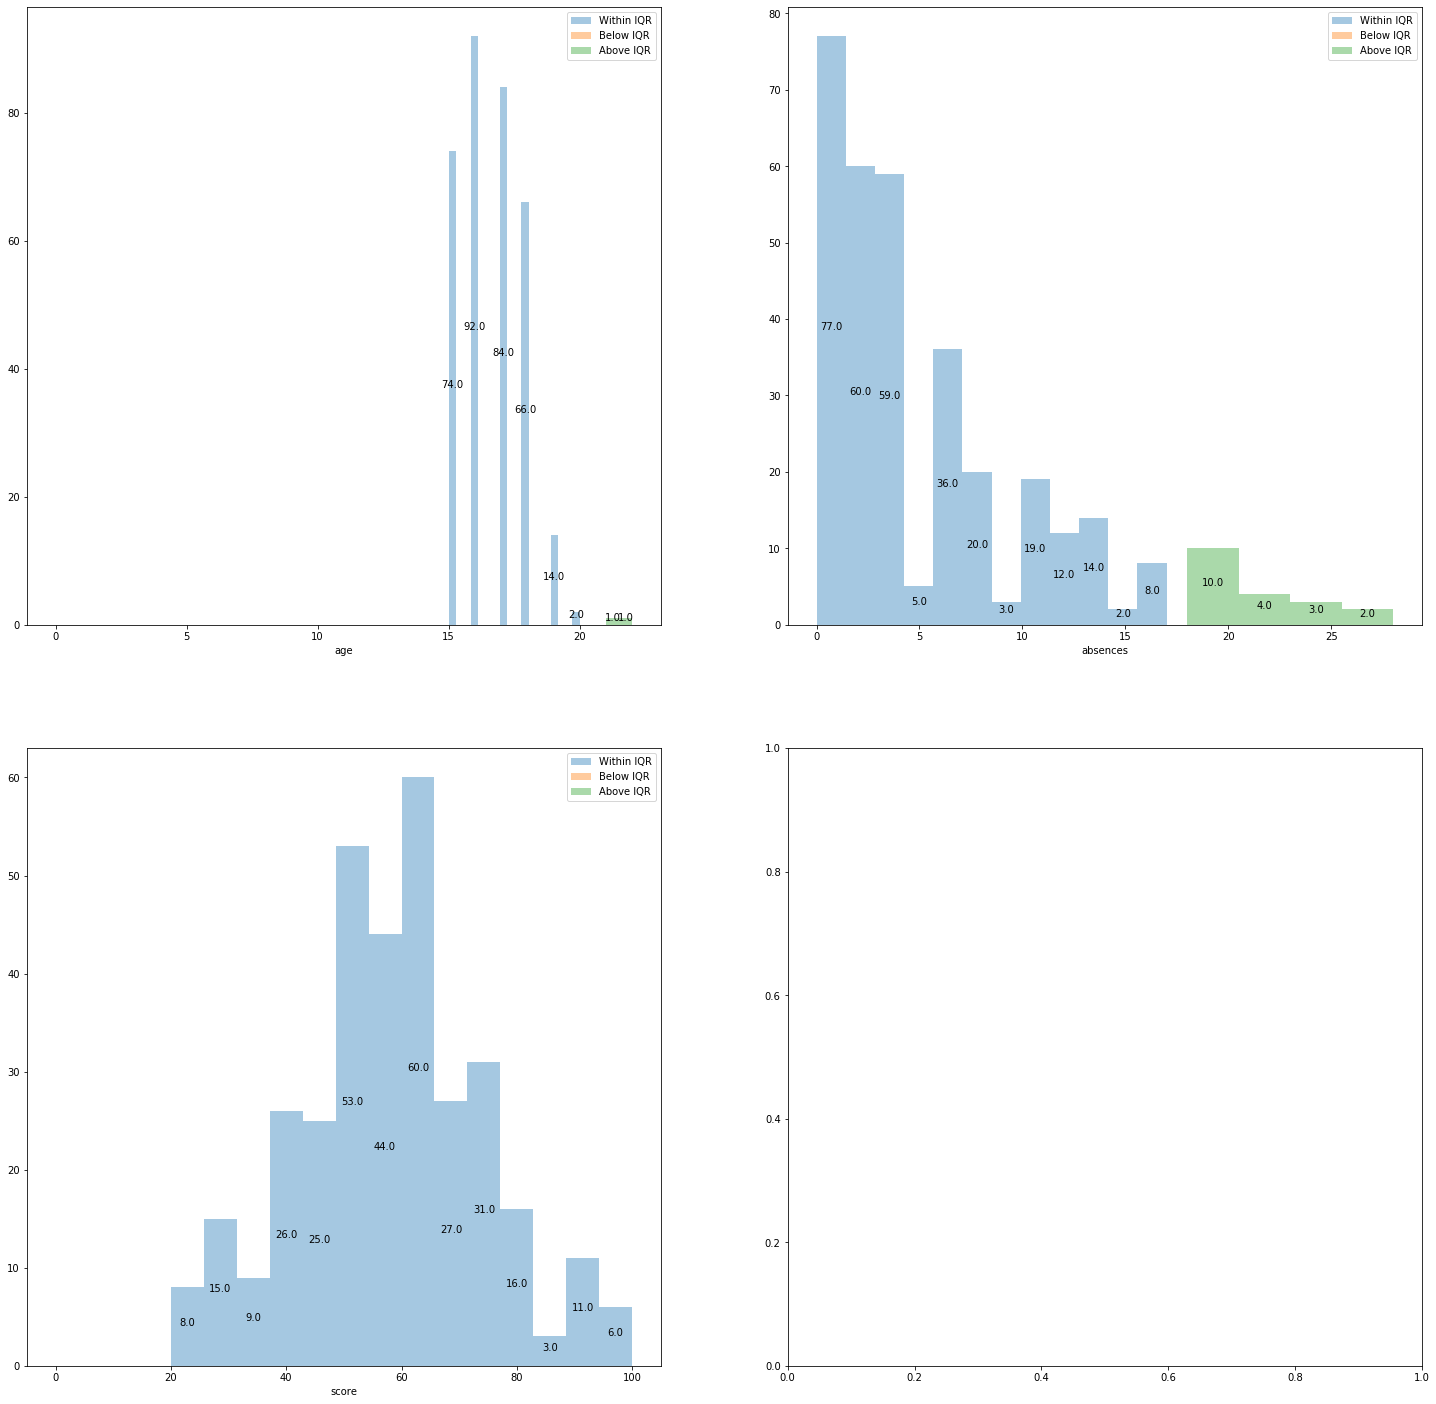

In [53]:
# After removing rows with outliers for column absence there are no more null values in any of the columns.
# Let's run visualization one more time to double check
mass_visualize_grid('num', cols_numeric, 2, df_students)

# Correlation analysis of numeric variables

In [54]:
# building a corelation matrix
df_students[['age', 'absences', 'score']].corr()

,age,absences,score
age,1.000000,0.205553,-0.117313
absences,0.205553,1.000000,-0.218907
score,-0.117313,-0.218907,1.000000


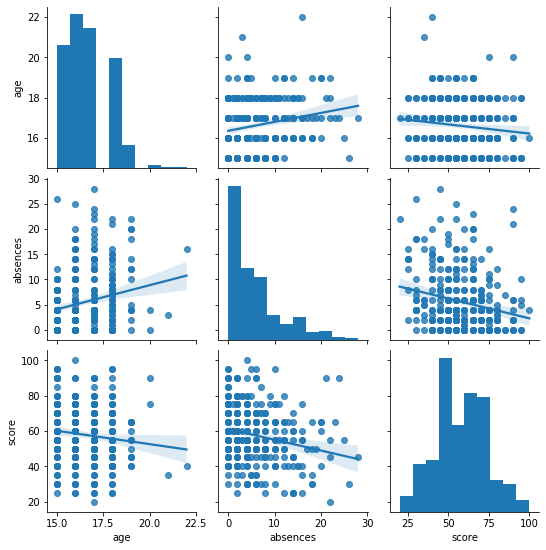

In [55]:
sns.pairplot(df_students[['age', 'absences', 'score']],  kind = 'reg')

# Notes after correlation analysis of numeric variables

1) Looking on correlation matrix and a pairplot it seems that there are no correlated variables that need to be removed from the dataset.

2) Age and absences are weakly correlated with target variable score.

# Assessing the effect of categorical variables on a target variable

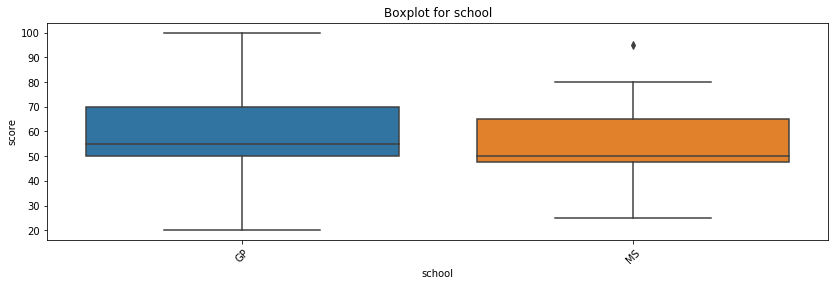

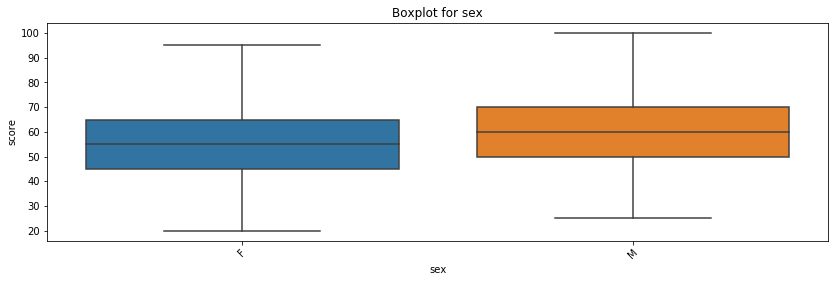

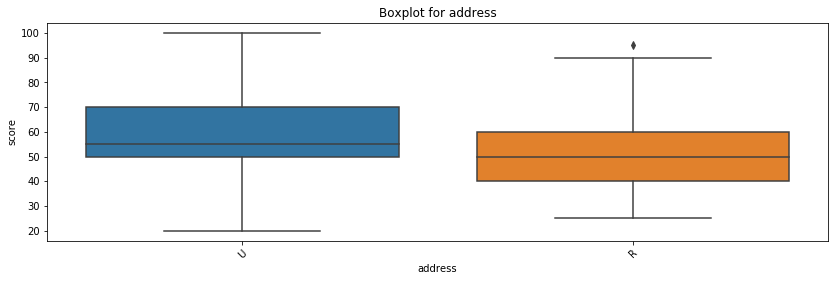

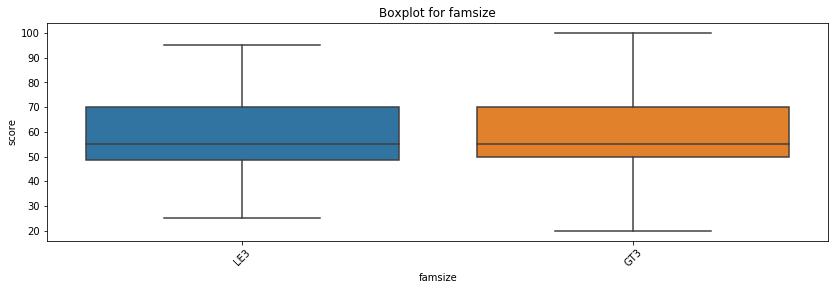

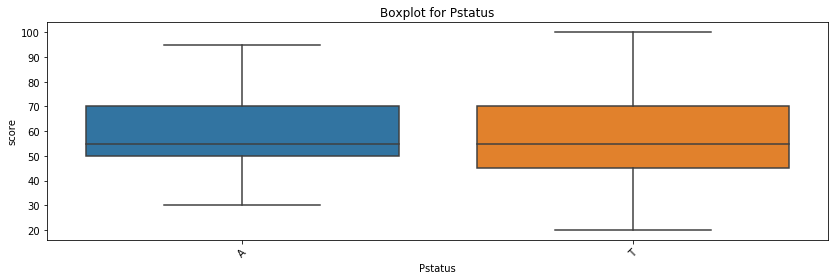

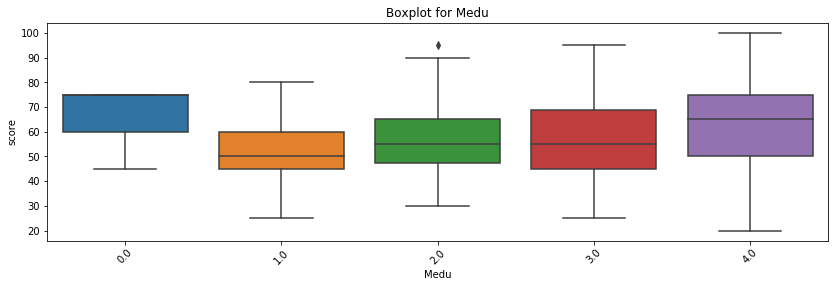

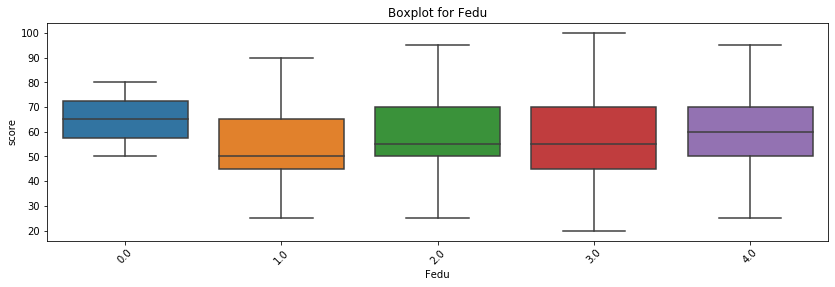

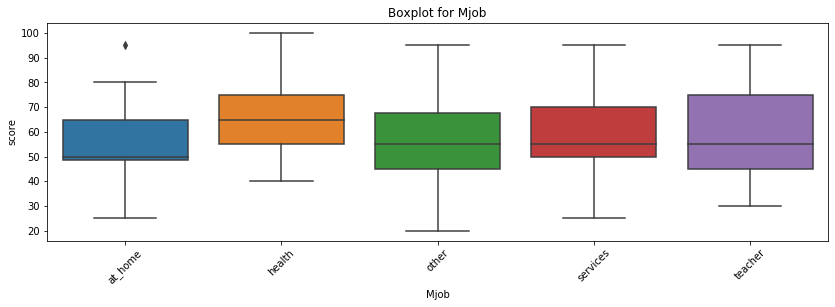

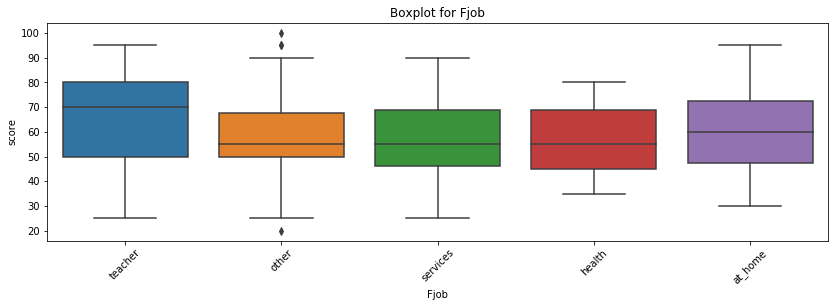

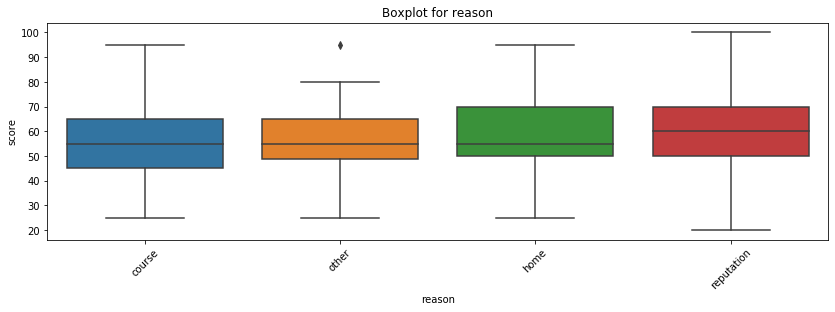

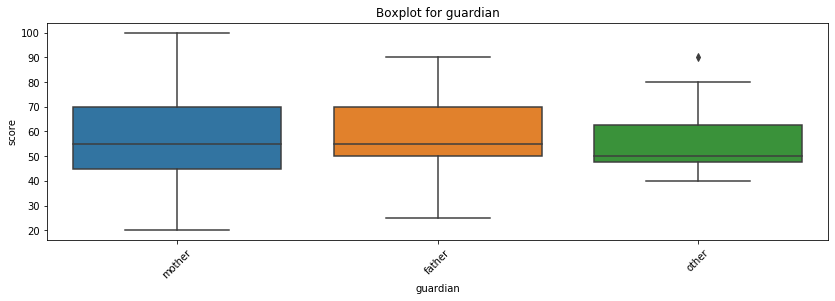

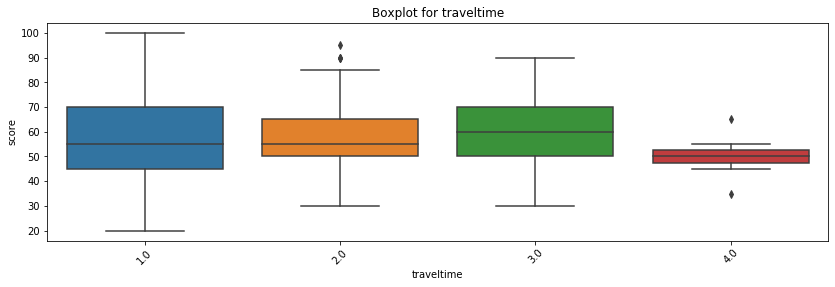

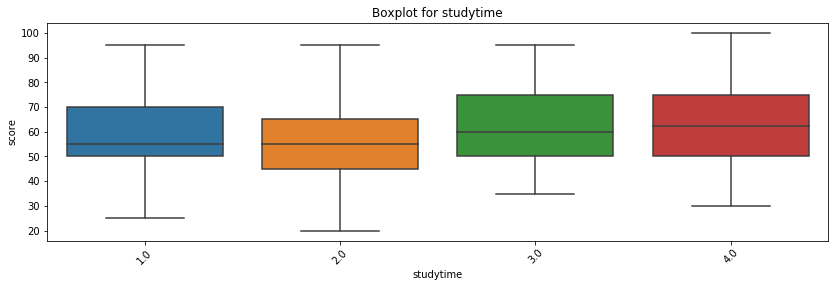

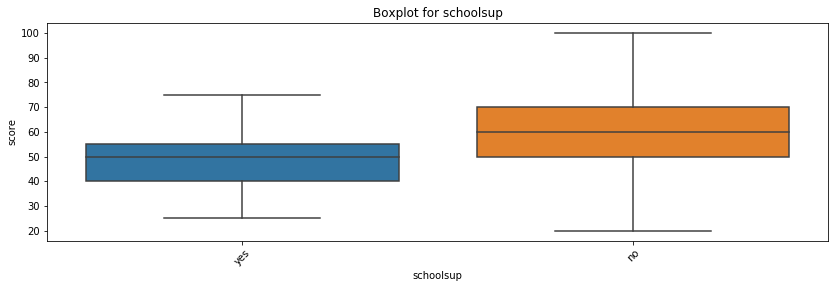

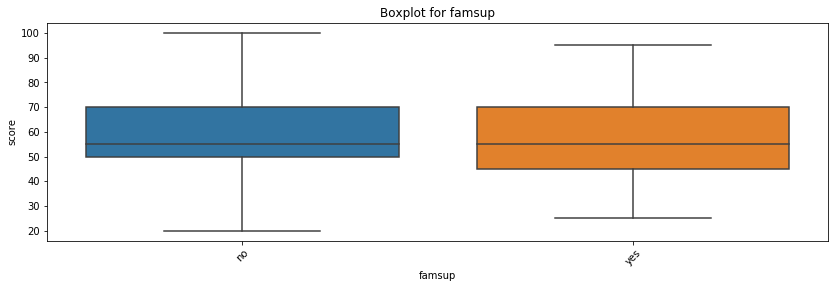

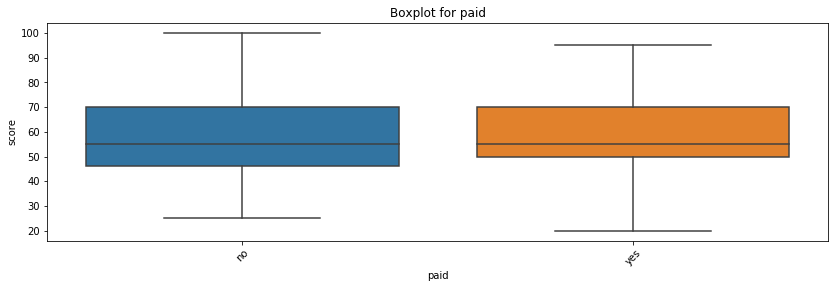

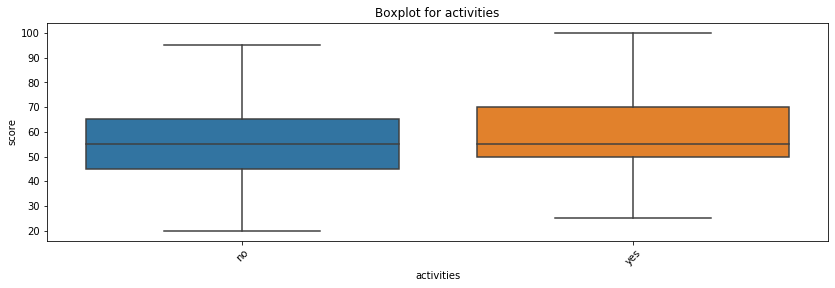

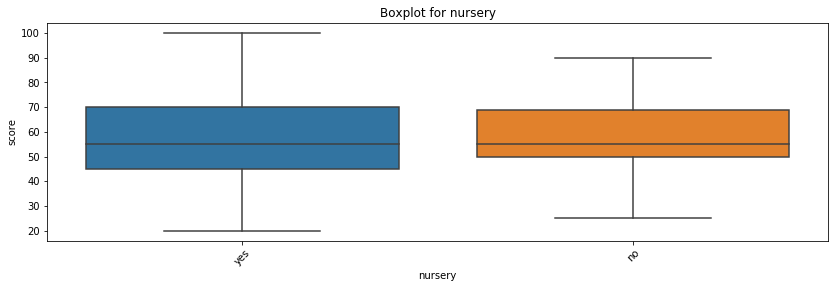

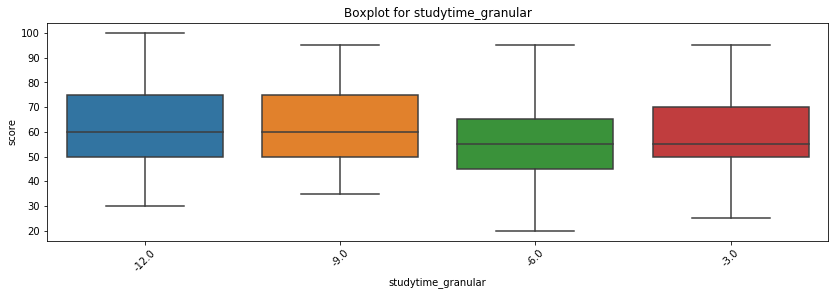

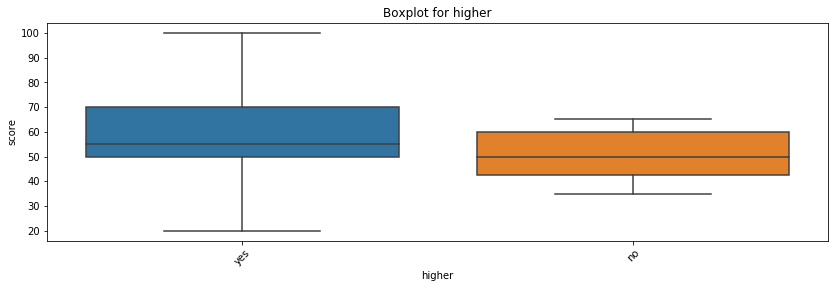

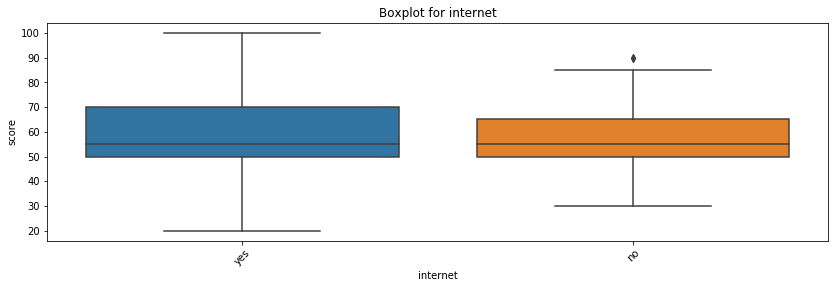

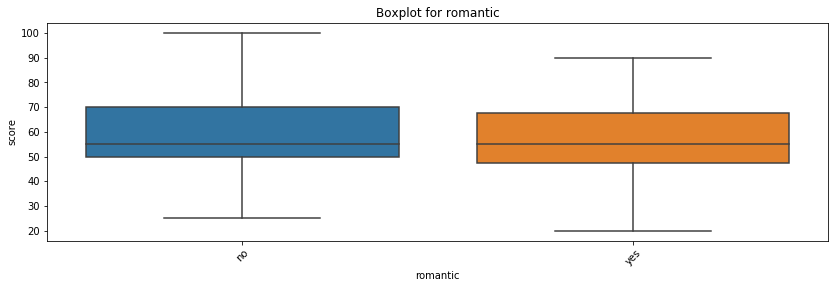

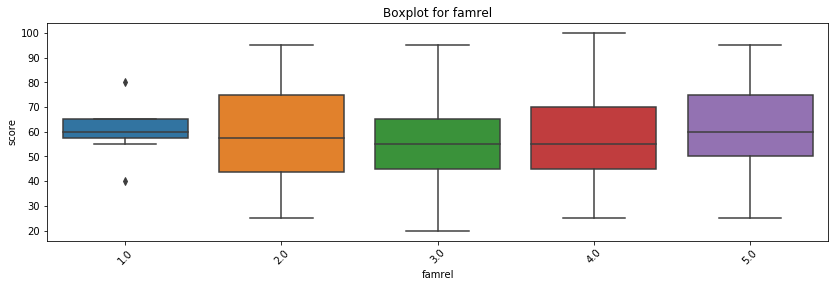

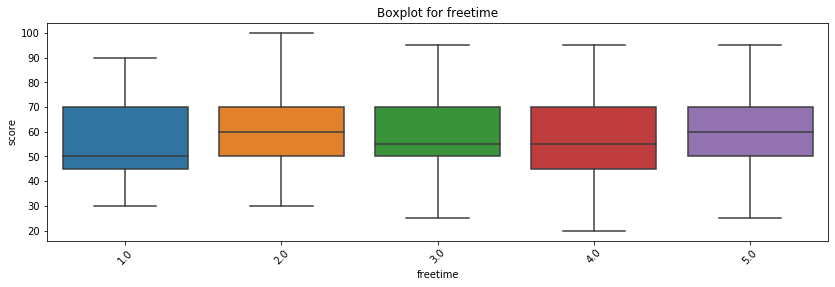

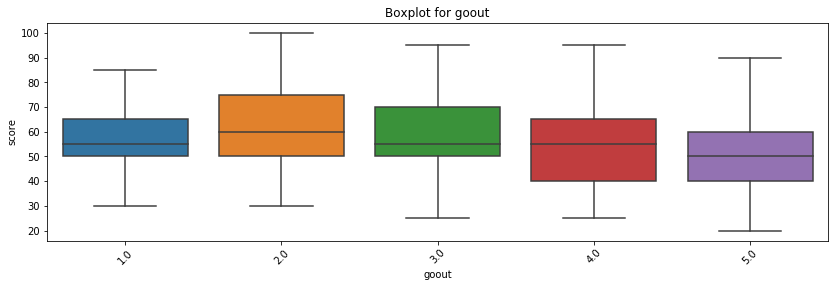

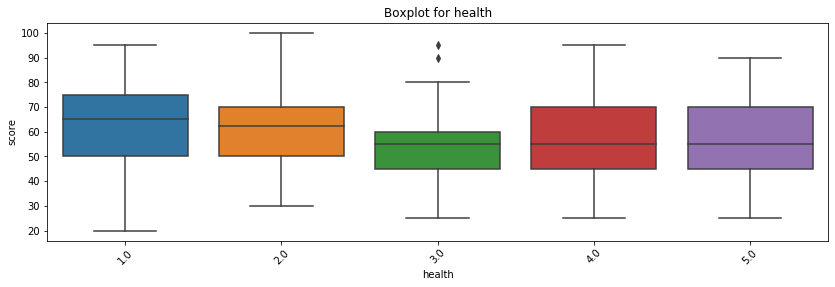

In [56]:
# visual assessment
for c in cols_categorical:
    get_boxplot(c, 'score', df_students)

In [57]:
# getting a list of statistically significant categories using Student's test
significant_categories = []
for c in list(cols_categorical):
    result = get_stat_dif(c,  df_students)
    if result != None:
        significant_categories.append(result)
significant_categories

Statistically significant differences found for column: address
Statistically significant differences found for column: Medu
Statistically significant differences found for column: Mjob
Statistically significant differences found for column: studytime
Statistically significant differences found for column: schoolsup
Statistically significant differences found for column: studytime_granular
Statistically significant differences found for column: goout


['address',
 'Medu',
 'Mjob',
 'studytime',
 'schoolsup',
 'studytime_granular',
 'goout']

# Creating a final dataframe for the model

In [58]:
# gathering a list of columns in a final dataframe
final_column_list = significant_categories + cols_numeric

# I still don't know what studytime_granular stands for
# this column will be dropped for now but in a real life scenario
# I would try to find out the meaning of this column and use it in
# a model if the meaning is found
final_column_list.remove('studytime_granular')

# creating a pre-final dataframe (not encoded)
df_pre_final = df_students[final_column_list].copy()

# creating a final dataframe (text values be label-encoded)
df_final = df_pre_final.copy()

# label-encode (turn text values into numbers for easy consumption
# by machine learning model) all the columns that need encoding
for c in ['address', 'Mjob', 'schoolsup']:
    # using pandas built-in type 'category'
    df_final[c] = df_final[c].astype('category')
    # creating a new column with original name and _cat
    # added in the end as well as categorizing it
    df_final[f'{c}_cat'] = df_final[c].cat.codes
    # dropping original column
    df_final.drop(c, axis=1, inplace=True)
    # converting _cat column to number
    df_final[f'{c}_cat'] = df_final[f'{c}_cat'].astype('int')

df_final

,Medu,studytime,goout,age,absences,score,address_cat,Mjob_cat,schoolsup_cat
0,4.0,2.0,4.0,18,6.0,30.0,1,0,1
1,1.0,2.0,3.0,17,4.0,30.0,1,0,0
2,1.0,2.0,2.0,15,10.0,50.0,1,0,1
3,4.0,3.0,2.0,15,2.0,75.0,1,1,0
4,3.0,2.0,2.0,16,4.0,50.0,1,2,0
...,...,...,...,...,...,...,...,...,...
388,3.0,2.0,4.0,18,0.0,40.0,1,4,0
391,3.0,1.0,5.0,17,3.0,80.0,1,3,0
392,1.0,1.0,3.0,21,3.0,35.0,0,2,0
393,3.0,1.0,1.0,18,0.0,50.0,0,3,0


# Final report and conclusions

## Intro

We were given a data set of 30 columns and 395 rows. This data set described math exam scores for students of age between 15 and 22 years old. The data was saved into a dataframe df_students.

Basic description of the dataframe (including the number of unique values for every column) was obtained using df_students.info(). This method was used multiple times throughout the analysis to check how the dataframe changed after certain manipulation.

Columns were separated into categorical and numeric. A separate list of ordinal column (subset of categorical) was created just in case, but never actually used.

Multiple helper functions were defined in a block called "Definitions of helper functions are in a cell below". These functions were later used to simplify visualization and data manipulation. Each function got a docstring and individual comments to make it more comprehensive.

## Categorical variables


Some rows contained values that were incorrectly entered. That's why one value in column Fedu was changed from 40 to 4 and one value in column famrel was changed from -1 to 1.

Column studytime_granular was dropped because it had no description in the task. This column, however, showed some statistically significant difference in Student's test. If in future a real meaning of this column is obtained it can be returned back to the training set.

Column failures was dropped because it's really not clear what the values in this column mean. Based on the description 0 can both mean 0 failures and number of failures > 3. It doesn't make any sense. 

Missing values were replace with actual values based on their frequency distribution (column freq_dict in a dataframe df_description). Of course, a more simple approach would be to simply replace missing values with mode, but this approach would be biased towards the most popular value and wouldn't take into account the fact that other values could also appear in a sample. Custom made function fill_na_by_frequency() was used for the replacement. Another (describe_dataframe()) function was used to populate dataframe df_description. Please see function descriptions in a corresponding section. 

Remaining categorical values were checked using a Student's test to understand if there's a significant effect of the values in each column on a target variable (score). The list of final categorical variables looked like this: 'address', 'Medu', 'Mjob', 'studytime', 'schoolsup','goout'.

## Numeric variables

Target variable score had some missing values (6 rows). Rows with missing values were removed in the beginning.

What seemed weird about the score is that 37 values had a score 0. The only way I could interpret this phenomena was that 37 students didn't attend an exam at all. Not attending an exam had nothing to do with scoring. That's why this column was dropped. However, it can be used in a different model for predicting, for example, if a student will choose to pass a math exam or not. However, that's a different task that requires a different analysis.

Outliers in numeric variables were determined using an interval between 25th percentile - 1.5*IQR and 75th percentile + 1.5*IQR. However, some values for age (22) and absences (all below 30) were left in the dataset even thou they were technically outliers simply because they were too close to the main sample of data and it would be a shame to lose them. All the rows with absences >= 30 were removed from the dataset.

Pair plot and correlation matrix were used to find correlated numeric variables. However, there were no such variables - so nothing was removed.

# Result

The result was written into df_final data frame. Categorical values of columns 'address', 'Mjob', 'schoolsup' were encoded using labels (approach described in section "Creating a final dataframe for the model"). The model was prepared for consumption by machine learning algorithms. However, in my opinion, the data set could be enhanced before using it for model training (see weak parts of the dataset below). 

##### Weak parts of the data set:

1) Only 2 schools were present in the data set. It's not very representative if you want to predict the situation in other schools as well because the model might be biased.

2) Column studytime_granular had no description and therefore had to be removed. That's sad because it looked like a good predictor.

3) Column failures was weird because based on the description 0 can mean both 0 and a value of > 3. That didn't make much sense to me. 